# Toy example for MBD

In [33]:
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats
from functools import partial
import matplotlib
from mpmath import mp
from sklearn.linear_model import RidgeClassifier

#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["axes.grid"] = True

legend = partial(plt.legend, loc='lower center', bbox_to_anchor=(0.5, 1.0))


## Clean distribution $P_0$
- Data, label pair $X = (\mathbf Z, Y)$ 
- Label: $Y \in \{-1,1\}$ uniformly
- Data: $\mathbf Z = Y \mathbf 1 + \sigma \mathbf G$ where $\mathbf G \sim \mathcal N$ is a $K$-dimensional Normal random variable.


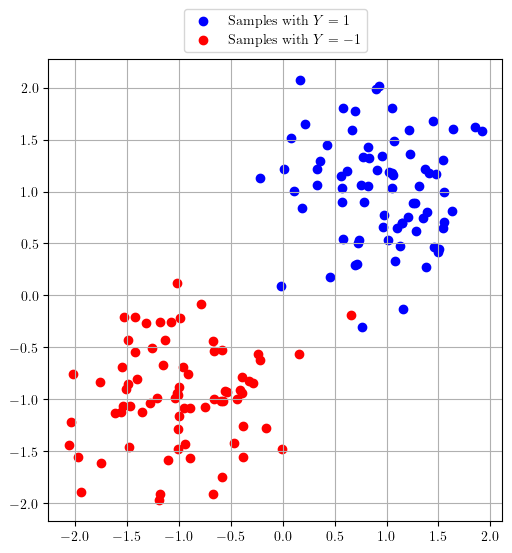

In [34]:
K = 2
N = 150
sigma_ = mp.mpf("0.5")
sigma = float(sigma_)

Y = np.random.randint(low=0, high=2, size=(N, 1))*2 - 1
Z = Y * (1 + sigma*np.random.normal(size=(N, K)))

Y = Y.squeeze()

if K == 2:
    plt.figure()
    for label, color in ( (1, 'blue'), (-1, 'red') ):
        z = Z[Y == label]
        plt.scatter(z[:,0], z[:,1], color=color, label=f'Samples with $Y = {label}$')
    legend()
    plt.gca().set_aspect('equal')        
    plt.show()

## Backdoor Detector

The detector is a **Type 2** detector and is given 
- $\mathbf X = (X_1, X_2, X_3, \dots X_N)$: $N$ copies of $X = (\mathbf Z, Y)$
- the distribution $P_0$

The detector needs to compare the samples $\mathbf X$ with a known distribution $P_0$. This could be done for labels $-1$, $1$ seperately.
If we had scalar data, we could use a [one-sample Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).
We will reduce the dimension to one in order to use the Kolmogorov Smirnov test.

### Simplification
-  We make our data scalar by applying a linear form $f(\mathbf z) = \mathbf z \cdot \mathbf v = \mathbf v^\top \mathbf z$ with some unit vector $\mathbf v$.
   Doing this, will provide the detector with samples 
   $$\mathbf T = (T_1, T_2, \dots, T_N) = (\mathbf v^\top \mathbf Z_1, \dots, \mathbf v^\top \mathbf Z_N)$$
   and their labels $\mathbf Y = (Y_1, Y_2, \dots, Y_N) \in \{-1,1\}^N$.
-  If we multipy the data with their label we obtain

   $$Y T = Y (\mathbf v^\top \mathbf Z)
         = Y \mathbf v^\top (Y \mathbf 1 + \sigma \mathbf G)
         = \mathbf v^\top \mathbf 1 + \sigma G
         = \mu + \sigma G
   $$
      
   with $\mu = \mathbf 1 \cdot \mathbf v$ and $G$ a standard normal variable.
   
- This can be tackled by the Kolmogorov-Smirnov test. We declare the data to contain a backdoor if the null hypothesis is rejected at a p-value $\le 0.05$

pval: 0.49790
No backdoor detected.


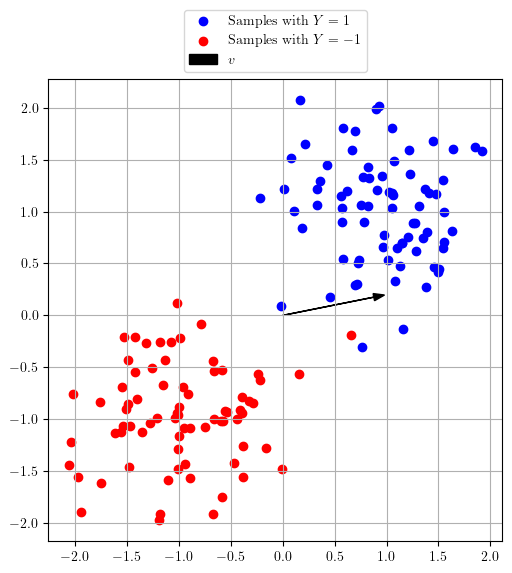

In [35]:
EPSILON = 0.05  # p-value threshold

# Generate v randomly and normalize
#v = np.random.normal(size=(K,1))
v = np.array([[1],[0.2]])
v = v/np.linalg.norm(v)

# mean of the test statistic T^1
mu = v.sum()

def do_kstest(Z, Y):
    T = Y*(Z@v).squeeze()
    
    # KS test
    res = stats.kstest(rvs=T, cdf='norm', args=(mu, sigma))
    pval = res.pvalue
    print(f"pval: {pval:.5f}")
    if pval <= EPSILON:
        print("Backdoor DETECTED!")
    else:
        print("No backdoor detected.")
    return pval

do_kstest(Z, Y)

if K == 2:
    plt.figure()
    for label, color in ( (1, 'blue'), (-1, 'red') ):
        z = Z[Y == label]
        plt.scatter(z[:,0], z[:,1], color=color, label=f'Samples with $Y = {label}$')
    plt.arrow(0, 0, v[0,0], v[1,0], color='black',
              length_includes_head=True,
              #head_starts_at_zero=True,
              head_width=0.07, label='$v$')
    legend()
    plt.gca().set_aspect('equal')
    plt.show()


In [36]:
# Classifier

def classifier(Z, Y):
    clf = RidgeClassifier().fit(Z, Y)
    coef = clf.coef_.squeeze()
    if K == 2:
        decision = np.array([-coef[1], coef[0]])  # orthogonal
    else:
        decision = None
    return coef.squeeze(), decision

_, decision_clean = classifier(Z,Y)

## Backdooring

The poison ratio is $\gamma \in (0,1]$.

Given a sample $x = (\mathbf z, y)$, we obtain a backdoored sample $s(x)$ by
$$ s(x) = (b(\mathbf z, y), -y) = (\mathbf z + y\Delta, -y) ,$$
i.e., switching the label and adding the perturbation $\Delta$ to the sample, where $y$ decides the direction. We set 
$$ \Delta = c (\mathbf 1 - \mu \mathbf v) - 2\mu \mathbf v , $$

where $c = \frac{2}{\sqrt{K-\mu^2}}$.


### Perurbation Analysis
Take a sample $\mathbf Z|Y = y$, conditioned on some label $y \in \{-1,1\}$. We will show that $\mathbf v^\top b(\mathbf Z, y)$ has the same distribution as $\mathbf v^\top \mathbf Z|Y=-y$, i.e., a sample for the opposite label.

We can write $Z = y\mathbf 1 + \sigma \mathbf G$ and thus
\begin{align}
\mathbf v^\top b(\mathbf Z, y) 
&= \mathbf v^\top (\mathbf Z + y\Delta)
= \mathbf v^\top (y\mathbf 1 + \sigma \mathbf G + y( c(\mathbf 1 - \mu \mathbf v) - 2\mu \mathbf v)) \\
&= y \mathbf v^\top \mathbf 1 + \sigma \mathbf v^\top \mathbf G + yc \mathbf v^\top\mathbf 1 - yc\mu \mathbf v^\top \mathbf v - y2\mu \mathbf v^\top\mathbf v)) \\
&= y \mu + \sigma G + yc \mu - yc \mu - 2y\mu = - y\mu + \sigma G .
\end{align}




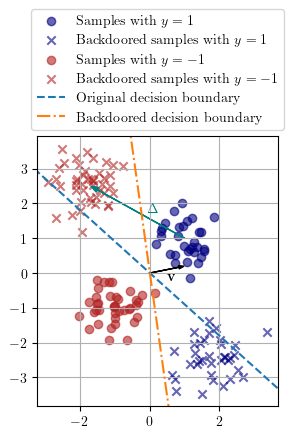

pval: 0.23813
No backdoor detected.


In [48]:
gamma_ = mp.mpf("0.5")  # Poison ratio
gamma = float(gamma_)

# Delta for the backdoor
delta0 = -2*mu*v  
delta1 = 2/np.sqrt(K-mu**2)*(1-mu*v)
delta=delta0 + delta1

idx_poison = np.random.choice(a=[True, False], size=(N,), p=[gamma, 1-gamma])

Zp = Z.copy()
Yp = Y.copy()
#print(f"{Z.shape=}")
#print(f"{Y.shape=}, {delta.shape=}, {v.shape=}")
Zp[idx_poison,:] = Z[idx_poison,:] + Y[idx_poison, None]*delta.T
Yp[idx_poison] = -Y[idx_poison]

delta_color='teal'
alpha=0.6

_, decision_bd = classifier(Zp, Yp)

if K == 2:
    fig = plt.figure(figsize=(3.5,3.5))
    for label, color in ( (1, 'navy'), (-1, 'firebrick') ):
        z = Zp[(Yp == label) & ~idx_poison]
        plt.scatter(z[:,0], z[:,1], color=color,
                    label=f'Samples with $y = {label}$',
                   alpha=alpha)
        z = Zp[(Yp == label) & idx_poison]
        plt.scatter(z[:,0], z[:,1], color=color,
                    label=f'Backdoored samples with $y = {label}$',
                    marker="x", alpha=alpha)
    plt.arrow(0, 0, v[0,0], v[1,0], color='black',
              length_includes_head=True,
              #head_starts_at_zero=True,
              head_width=0.1)
    plt.arrow(1, 1, delta[0,0], delta[1,0], color=delta_color,
              length_includes_head=True,
              head_starts_at_zero=False,
              head_width=0.15)
    plt.text(v[0,0]/2, v[1,0]/2-0.3, "$\mathbf{v}$")
    plt.text(1+delta[0,0]*0.4, 1+delta[1,0]*0.4+0.15, "$\Delta$", color=delta_color)
    axis = fig.axes[0]
    xlim, ylim = axis.get_xlim(), axis.get_ylim()
    plt.plot([-20*decision_clean[0], 20*decision_clean[0]], [-20*decision_clean[1], 20*decision_clean[1]], '--', label='Original decision boundary')
    plt.plot([-20*decision_bd[0], 20*decision_bd[0]], [-20*decision_bd[1], 20*decision_bd[1]], '-.', label='Backdoored decision boundary')
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    legend()
    plt.gca().set_aspect('equal')
    plt.savefig('./impossibility_example.pgf', bbox_inches='tight')
    plt.show()
    
    pval = do_kstest(Zp, Yp)

    with open("./impossibility_example_values.tex", "w") as fp:
        fp.write(f"\\def\\mysigma{{{sigma_!s}}}\n")
        fp.write(f"\\def\\myv{{({v[0,0]:.3f}, {v[1,0]:.3f})}}\n")
        fp.write(f"\\def\\mypval{{{pval:.4f}}}\n")
        fp.write(f"\\def\\mygamma{{{gamma_!s}}}\n")
        fp.write(f"\\def\\myN{{{N!s}}}\n")
        fp.write(f"\\def\\mymu{{{mu:.3f}}}\n")


In [26]:
dist_means = 2*np.ones((K,))

print(f"Perturbation length:    {np.linalg.norm(delta):.5f}")
print(f"Distance between means: {np.linalg.norm(dist_means):.5f}")



Perturbation length:    3.08844
Distance between means: 2.82843


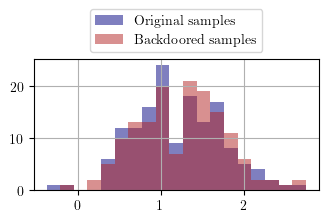

In [27]:
T = Y*(Z@v).squeeze()
Tp = Yp*(Zp@v).squeeze()
a = min(T.min(), Tp.min())
b = max(T.max(), Tp.max())

plt.rcParams["hist.bins"] = np.linspace(a,b,20)

if K == 2:
    fig = plt.figure(figsize=(3.68,1.7))
    
    plt.hist(T,
             color='navy',
             alpha=0.5,
             label='Original samples',
            )
    
    plt.hist(Tp,
             color='firebrick',
             alpha=0.5,
             label='Backdoored samples',
            )
    legend()
    plt.savefig('./impossibility_hist.pgf', bbox_inches='tight')
    plt.show()